# Deep Learning and Neural Network - Question 1
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

# Outline
- [ 0 - Packages ](#0)
- [ 1 - Data Proprocessing ](#1)
- [ 2 - Implementation ](#2)
- [ 3 - Result Analysis ](#3)

---

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [scikit-learn](https://scikit-learn.org) is a Python module for machine learning.
- [albumentations](https://albumentations.ai) is a computer vision tool that boosts the performance of deep convolutional neural networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Flatten, Dropout, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError, R2Score
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

np.random.seed(24)

---

<a name="2"></a>
## 2 - Preparation

### ◆ Autoencoder

In [2]:
input_dim = 8
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(7, activation='relu'),
    Dense(6, activation='relu'),
    Dense(4, activation='relu'),
    Dense(6, activation='relu'),
    Dense(7, activation='relu'),
    Dense(8, activation='linear'),
])
autoencoder.compile(optimizer='Adam', loss='mse')
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 7)                   │              63 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │              49 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │              64 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282 (1.10 KB)

 Trainable params: 282 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

input_dim = 8
hidden_dim = 6
encoding_dim = 3
input_layer = Input(shape=(input_dim,))
encoder = Dense(hidden_dim, activation='relu')(input_layer)
bottleneck = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(hidden_dim, activation='relu')(bottleneck)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='Adam', loss='mse')
autoencoder.summary()

### ◆ Huber Loss

In [3]:
def Huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * np.abs(error) - 0.5 * delta**2
    return np.where(is_small_error, squared_loss, linear_loss)

### ◆ Slime Mould

In [4]:
def objective_function(x):
    return np.sum(x**2)

def slime_mould_algorithm(obj_func, dim, n_population, max_iter, bounds):
    lower, upper = bounds
    population = np.random.uniform(lower, upper, (n_population, dim))
    fitness = np.array([obj_func(ind) for ind in population])    
    best_solution = population[np.argmin(fitness)]
    best_fitness = np.min(fitness)
    for iteration in range(max_iter):
        normalized_fitness = (fitness - np.min(fitness)) / (np.max(fitness) - np.min(fitness) + 1e-8)        
        weights = 1 / (1 + np.exp(-10 * (normalized_fitness - 0.5)))
        for i in range(n_population):
            r1 = np.random.rand()
            r2 = np.random.rand()            
            if r1 < weights[i]:
                population[i] += r2 * (population[i] - best_solution)
            else:
                random_index = np.random.randint(n_population)
                population[i] += r2 * (population[random_index] - population[i])
        population = np.clip(population, lower, upper)
        fitness = np.array([obj_func(ind) for ind in population])
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]
        print(f"Iteration {iteration + 1}/{max_iter}, Best Fitness: {best_fitness}")
    return best_solution, best_fitness

In [5]:
def slime_mould_algorithm(objective_function, dim, bounds, population_size=20, max_iter=50):
    positions = np.random.uniform(bounds[0], bounds[1], (population_size, dim))
    fitness = np.array([objective_function(p) for p in positions])
    best_index = np.argmin(fitness)
    best_position = positions[best_index]
    best_fitness = fitness[best_index]
    for t in range(max_iter):
        sorted_indices = np.argsort(fitness)
        positions = positions[sorted_indices]
        fitness = fitness[sorted_indices]
        for i in range(population_size):
            if i <= population_size // 2:
                w = 1
            else:
                w = -1
            rand_index = random.randint(0, population_size - 1)
            positions[i] = positions[0] + w * (positions[rand_index] - positions[i]) * random.random()
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])
        fitness = np.array([objective_function(p) for p in positions])
        best_index = np.argmin(fitness)
        if fitness[best_index] < best_fitness:
            best_fitness = fitness[best_index]
            best_position = positions[best_index]
    return best_position, best_fitness

In [6]:
def slime_mould_algorithm(objective_function, dim, bounds, population_size=20, max_iter=50):
    positions = np.random.uniform(bounds[0], bounds[1], (population_size, dim))
    fitness = np.array([objective_function(p) for p in positions])
    best_index = np.argmin(fitness)
    best_position = positions[best_index]
    best_fitness = fitness[best_index]
    for t in range(max_iter):
        sorted_indices = np.argsort(fitness)
        positions = positions[sorted_indices]
        fitness = fitness[sorted_indices]
        for i in range(population_size):
            if i <= population_size // 2:
                w = 1
            else:
                w = -1
            rand_index = random.randint(0, population_size - 1)
            if rand_index < population_size and i < population_size:
                positions[i] = positions[0] + w * (positions[rand_index] - positions[i]) * random.random()
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])
        fitness = np.array([objective_function(p) for p in positions])
        best_index = np.argmin(fitness)
        if fitness[best_index] < best_fitness:
            best_fitness = fitness[best_index]
            best_position = positions[best_index]
    return best_position, best_fitness

---

<a name="3"></a>
## 3 - Identification Method and Results

In [7]:
df = pd.read_csv('/kaggle/input/ca5-question1-dataset/Offshore Wind Farm Dataset1(WT5).csv', index_col=0)

In [8]:
data = np.array(df.iloc[:1440, :])

In [9]:
ind = int(len(data) * 0.8)
train = data[:ind]
test = data[ind:]

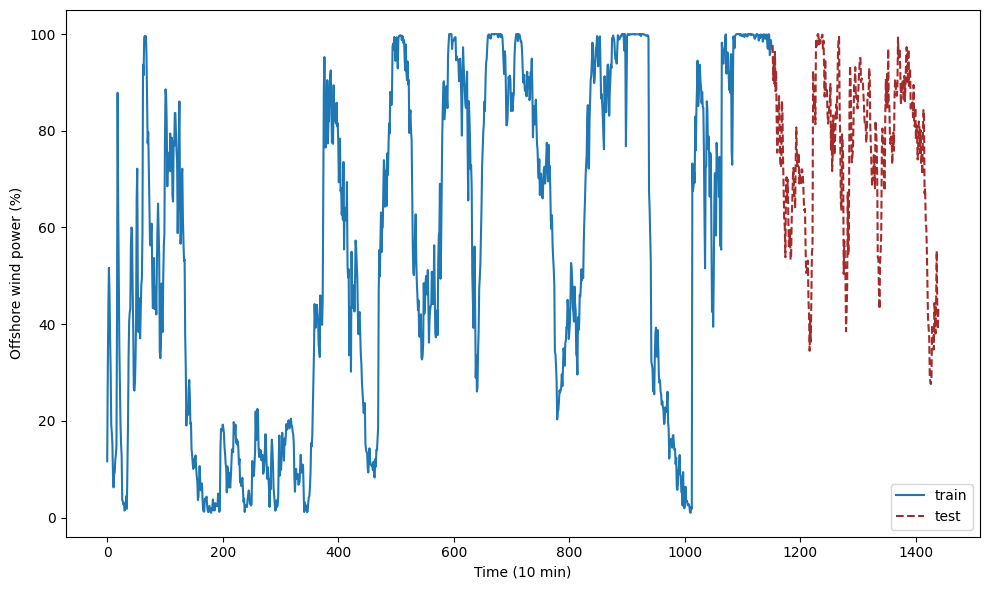

In [10]:
train_indices = np.arange(len(train))
test_indices = np.arange(len(train), len(train) + len(test))
plt.figure(figsize=(10, 6))
plt.plot(train_indices, train[:, 7], label='train')
plt.plot(test_indices, test[:, 7], label='test', linestyle='--', color='brown')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore wind power (%)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### ◆ Outlier Detection

In [11]:
def detect_outliers(data, window_size=48):
    data = np.array(data)
    outliers = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        window = data[start:end]
        mean = np.mean(window)
        variance = np.var(window)
        if abs(data[i] - mean) > 2 * variance:
            outliers.append(i)
    return outliers

In [12]:
outlier_indices = detect_outliers(data[:, 7])

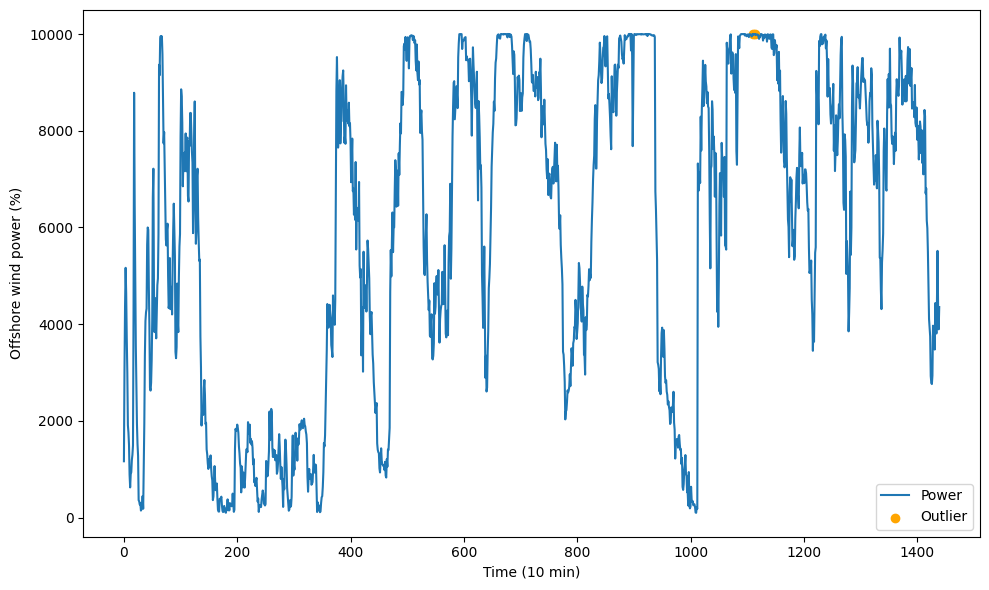

In [13]:
time = np.arange(len(data))
plt.figure(figsize=(10, 6))
plt.plot(time, data[:, 7] * 100, label="Power")
plt.scatter(time[outlier_indices], data[outlier_indices, 7] * 100, color="orange", label="Outlier")
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore wind power (%)")
plt.legend()
plt.tight_layout()
plt.show()

### ◆ Data Denoising

In [14]:
autoencoder.fit(data, data, epochs=200, verbose=0)
denoised_data = autoencoder.predict(data, verbose=0)

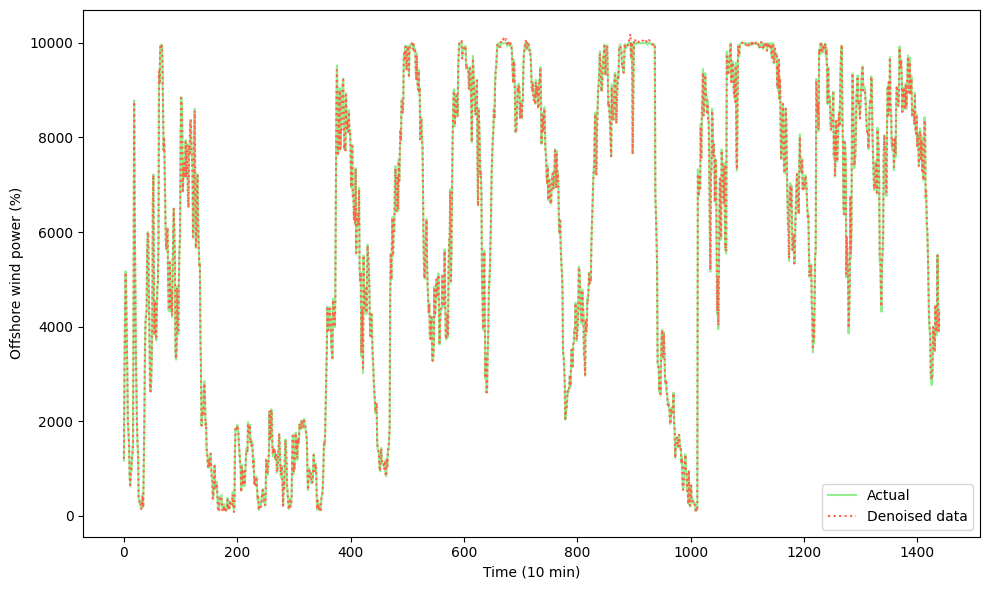

In [15]:
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(time, data[:, 7] * 100, color='lightgreen', label='Actual', linestyle='-')  # Solid green line
plt.plot(time, denoised_data[:, 7] * 100, color='tomato', label='Denoised data', linestyle=':')  # Dashed red line
plt.xlabel("Time (10 min)")
plt.ylabel('Offshore wind power (%)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### ◆ Data Preprocessing

In [16]:
def create_features_targets(data, lookback=144, prediction_steps=24):
    X, Y = [], []
    num_samples = len(data)
    num_features = data.shape[1]
    padded_data = np.pad(data, ((lookback, 0), (0, 0)), mode='constant', constant_values=0)
    num_samples = len(padded_data)
    for i in range(lookback, num_samples - prediction_steps + 1, prediction_steps):
        X.append(padded_data[i - lookback:i])
        Y.append(padded_data[i:i + prediction_steps, 7])
    return np.array(X), np.array(Y)

In [17]:
lookback, prediction_steps = 144, 1
X, Y = create_features_targets(denoised_data, lookback=lookback, prediction_steps=prediction_steps)
ind = int(len(X) * 0.8)
X_train, Y_train = X[:ind], Y[:ind]
X_test, Y_test = X[ind:], Y[ind:]
min_X = np.min(X_train, axis=0)
max_X = np.max(X_train, axis=0)
min_Y = np.min(Y_train, axis=0)
max_Y = np.max(Y_train, axis=0)
X_train = (X_train - min_X) / (max_X - min_X)
Y_train = (Y_train - min_Y) / (max_Y - min_Y)
X_test = (X_test - min_X) / (max_X - min_X)
Y_test = (Y_test - min_Y) / (max_Y - min_Y)

### ◆ Training 6 Models (Single Step)

In [18]:
lookback, prediction_steps = 144, 1
X, Y = create_features_targets(denoised_data, lookback=144, prediction_steps=1)
ind = int(len(X) * 0.8)
X_train, Y_train = X[:ind], Y[:ind]
X_test, Y_test = X[ind:], Y[ind:]
min_X = np.min(X_train, axis=0)
max_X = np.max(X_train, axis=0)
min_Y = np.min(Y_train, axis=0)
max_Y = np.max(Y_train, axis=0)
X_train = (X_train - min_X) / (max_X - min_X)
Y_train = (Y_train - min_Y) / (max_Y - min_Y)
X_test = (X_test - min_X) / (max_X - min_X)
Y_test = (Y_test - min_Y) / (max_Y - min_Y)

In [19]:
def MLP_model(input_shape, prediction_steps):
    model = Sequential([
        Input(shape=input_shape),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(prediction_steps, activation='linear')
    ])
    return model

def RNN_model(input_shape, prediction_steps):
    model = Sequential([
        Input(shape=input_shape),
        SimpleRNN(64, activation='relu', return_sequences=False),
        Dense(32, activation='relu'),
        Dense(prediction_steps, activation='linear')
    ])
    return model

def Transformer_model(input_shape, prediction_steps):
    inputs = Input(shape=input_shape)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)
    ff_output = Dense(64, activation='relu')(attention_output)
    ff_output = Dropout(0.1)(ff_output)
    ff_output = Dense(32, activation='relu')(ff_output)
    flatten = Flatten()(ff_output)
    outputs = Dense(prediction_steps, activation='linear')(flatten)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def train_model(model, loss_function, X_train, Y_train, epochs, batch_size, optimizer, metrics):
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return history

In [20]:
epochs = 50
batch_size = 32
optimizer = 'Adam'
loss_functions = {
    "MSE": MeanSquaredError(),
    "Huber": Huber()
}
metrics = [MeanAbsoluteError(), RootMeanSquaredError(), MeanAbsolutePercentageError()]
input_shape = (lookback,)
models = {
    "MLP_MSE": MLP_model((lookback, 8), prediction_steps),
    "MLP_Huber": MLP_model((lookback, 8), prediction_steps),
    "RNN_MSE": RNN_model((lookback, 8), prediction_steps),
    "RNN_Huber": RNN_model((lookback, 8), prediction_steps),
    "Transformer_MSE": Transformer_model((lookback, 8), prediction_steps),
    "Transformer_Huber": Transformer_model((lookback, 8), prediction_steps)
}

In [21]:
histories = {}
for model_name, model in models.items():
    loss_type = "MSE" if "MSE" in model_name else "Huber"
    histories[model_name] = train_model(model, loss_functions[loss_type], X_train, Y_train, epochs, batch_size, optimizer, metrics)
    print(f"Training {model_name} with {loss_type} loss done.")

Training MLP_MSE with MSE loss done.
Training MLP_Huber with Huber loss done.
Training RNN_MSE with MSE loss done.
Training RNN_Huber with Huber loss done.
Training Transformer_MSE with MSE loss done.
Training Transformer_Huber with Huber loss done.


### ◆ Metrics Prediction and Evaluation

In [22]:
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test, verbose=0)

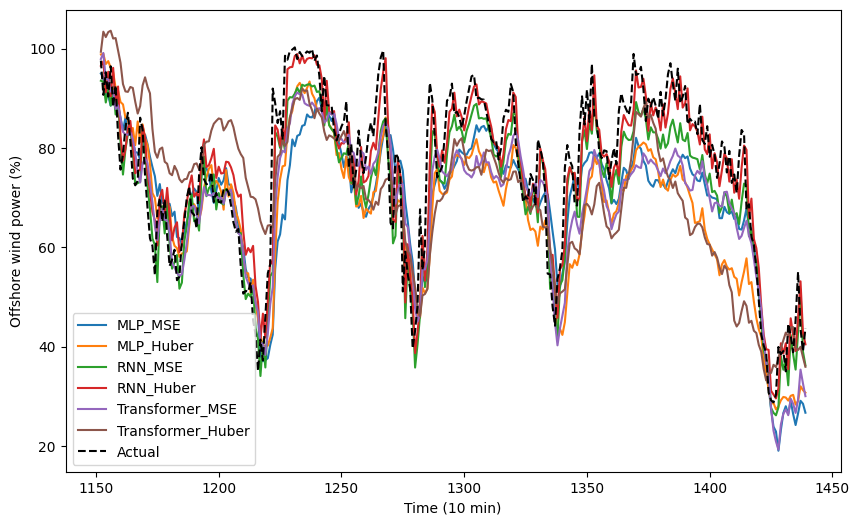

In [23]:
plt.figure(figsize=(10, 6))
for model_name, preds in predictions.items():
    preds = preds * (max_Y - min_Y) + min_Y
    plt.plot(test_indices, preds.flatten(), label=model_name)
Y_test = Y_test * (max_Y - min_Y) + min_Y
plt.plot(test_indices, Y_test.flatten(), label='Actual', linestyle='--', color='black')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore wind power (%)')
plt.legend()
plt.show()

In [24]:
results = {
    "Index": [],
    "Model": [],
    "MSE": [],
    "Huber": []
}
for model_name, history in histories.items():
    model_arch, model_loss = model_name.split("_")
    if model_loss in ["MSE", "Huber"]:
        results["Index"].extend(["MAE", "MAPE", "RMSE"])
        results["Model"].extend([model_arch] * 3)
        results["MSE"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "MSE" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "MSE" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "MSE" else None,
        ])
        results["Huber"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "Huber" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "Huber" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "Huber" else None,
        ])
df = pd.DataFrame(results)
df.sort_values(by=["Index", "Model"], inplace=True)
df = df.reset_index(drop=True)
for i in range(1, len(df), 2):
    odd_row = i
    even_row = i - 1
    if even_row < len(df):
        df.iloc[odd_row] = df.iloc[odd_row].fillna(df.iloc[even_row])
df1 = df.iloc[1::2].reset_index(drop=True)
df1

,Index,Model,MSE,Huber
0,MAE,MLP,0.041744,0.041905
1,MAE,RNN,0.040942,0.041595
2,MAE,Transformer,0.053986,0.048387
3,MAPE,MLP,5.956366,10.399977
4,MAPE,RNN,6.231303,1.551221
5,MAPE,Transformer,6.438055,8.807488
6,RMSE,MLP,0.057559,0.059330
7,RMSE,RNN,0.062102,0.061303
8,RMSE,Transformer,0.072309,0.063830


### ◆ Slime Mould for Transformer Hyperparameter (Optional)

In [25]:
def objective_function(learning_rate):
    lookback = 144
    epochs = 5
    batch_size = 32
    optimizer = Adam(learning_rate=learning_rate[0])
    loss_function = Huber()
    metrics = [MeanAbsoluteError(), RootMeanSquaredError(), MeanAbsolutePercentageError()]
    input_shape = (lookback, 8)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return history.history["loss"]

### ◆ Multi-step Prediction

#### ● t+4

In [26]:
lookback, prediction_steps = 144, 4
X, Y = create_features_targets(denoised_data, lookback=lookback, prediction_steps=prediction_steps)
ind = int(len(X) * 0.8)
X_train, Y_train = X[:ind], Y[:ind]
X_test, Y_test = X[ind:], Y[ind:]
min_X = np.min(X_train, axis=0)
max_X = np.max(X_train, axis=0)
min_Y = np.min(Y_train, axis=0)
max_Y = np.max(Y_train, axis=0)
X_train = (X_train - min_X) / (max_X - min_X)
Y_train = (Y_train - min_Y) / (max_Y - min_Y)
X_test = (X_test - min_X) / (max_X - min_X)
Y_test = (Y_test - min_Y) / (max_Y - min_Y)

In [27]:
epochs = 50
batch_size = 32
optimizer = 'Adam'
loss_functions = {
    "MSE": MeanSquaredError(),
    "Huber": Huber()
}
metrics = [MeanAbsoluteError(), RootMeanSquaredError(), MeanAbsolutePercentageError()]
input_shape = (lookback,)
models = {
    "MLP_MSE": MLP_model((lookback, 8), prediction_steps),
    "MLP_Huber": MLP_model((lookback, 8), prediction_steps),
    "RNN_MSE": RNN_model((lookback, 8), prediction_steps),
    "RNN_Huber": RNN_model((lookback, 8), prediction_steps),
    "Transformer_MSE": Transformer_model((lookback, 8), prediction_steps),
    "Transformer_Huber": Transformer_model((lookback, 8), prediction_steps)
}

In [28]:
histories = {}
for model_name, model in models.items():
    loss_type = "MSE" if "MSE" in model_name else "Huber"
    histories[model_name] = train_model(model, loss_functions[loss_type], X_train, Y_train, epochs, batch_size, optimizer, metrics)
    print(f"Training {model_name} with {loss_type} loss done.")

Training MLP_MSE with MSE loss done.
Training MLP_Huber with Huber loss done.
Training RNN_MSE with MSE loss done.
Training RNN_Huber with Huber loss done.
Training Transformer_MSE with MSE loss done.
Training Transformer_Huber with Huber loss done.


In [29]:
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test, verbose=0)

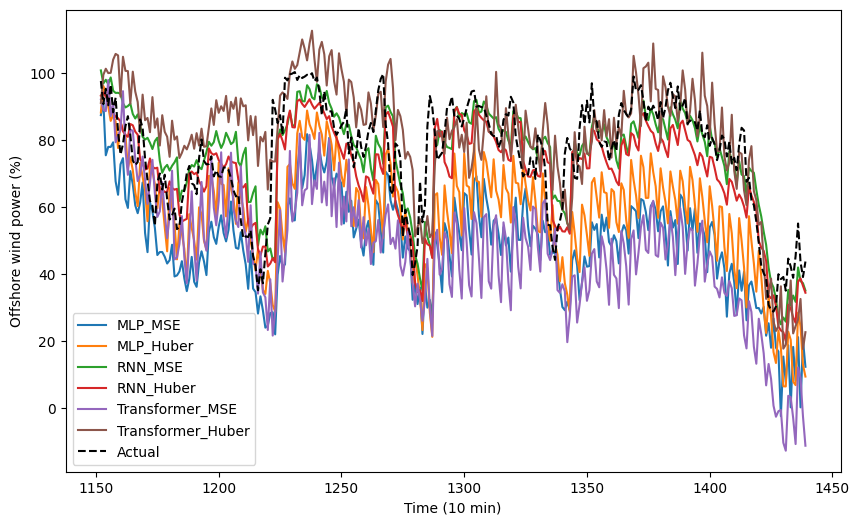

In [30]:
plt.figure(figsize=(10, 6))
for model_name, preds in predictions.items():
    preds = preds * (max_Y - min_Y) + min_Y
    plt.plot(test_indices, preds.flatten(), label=model_name)
Y_test = Y_test * (max_Y - min_Y) + min_Y
plt.plot(test_indices, Y_test.flatten(), label='Actual', linestyle='--', color='black')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore wind power (%)')
plt.legend()
plt.show()

In [31]:
results = {
    "Index": [],
    "Model": [],
    "MSE": [],
    "Huber": []
}
for model_name, history in histories.items():
    model_arch, model_loss = model_name.split("_")
    if model_loss in ["MSE", "Huber"]:
        results["Index"].extend(["MAE", "MAPE", "RMSE"])
        results["Model"].extend([model_arch] * 3)
        results["MSE"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "MSE" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "MSE" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "MSE" else None,
        ])
        results["Huber"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "Huber" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "Huber" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "Huber" else None,
        ])
df = pd.DataFrame(results)
df.sort_values(by=["Index", "Model"], inplace=True)
df = df.reset_index(drop=True)
for i in range(1, len(df), 2):
    odd_row = i
    even_row = i - 1
    if even_row < len(df):
        df.iloc[odd_row] = df.iloc[odd_row].fillna(df.iloc[even_row])
df4 = df.iloc[1::2].reset_index(drop=True)
df4

,Index,Model,MSE,Huber
0,MAE,MLP,0.093367,0.069099
1,MAE,RNN,0.062453,0.067038
2,MAE,Transformer,0.080162,0.067648
3,MAPE,MLP,22.217205,37.607859
4,MAPE,RNN,28.237775,23.173198
5,MAPE,Transformer,13.620536,25.397750
6,RMSE,MLP,0.119811,0.091921
7,RMSE,RNN,0.094069,0.099649
8,RMSE,Transformer,0.103653,0.087330


#### ●● t+8

In [32]:
lookback, prediction_steps = 144, 8
X, Y = create_features_targets(denoised_data, lookback=lookback, prediction_steps=prediction_steps)
ind = int(len(X) * 0.8)
X_train, Y_train = X[:ind], Y[:ind]
X_test, Y_test = X[ind:], Y[ind:]
min_X = np.min(X_train, axis=0)
max_X = np.max(X_train, axis=0)
min_Y = np.min(Y_train, axis=0)
max_Y = np.max(Y_train, axis=0)
X_train = (X_train - min_X) / (max_X - min_X)
Y_train = (Y_train - min_Y) / (max_Y - min_Y)
X_test = (X_test - min_X) / (max_X - min_X)
Y_test = (Y_test - min_Y) / (max_Y - min_Y)

In [33]:
epochs = 50
batch_size = 32
optimizer = 'Adam'
loss_functions = {
    "MSE": MeanSquaredError(),
    "Huber": Huber()
}
metrics = [MeanAbsoluteError(), RootMeanSquaredError(), MeanAbsolutePercentageError()]
input_shape = (lookback,)
models = {
    "MLP_MSE": MLP_model((lookback, 8), prediction_steps),
    "MLP_Huber": MLP_model((lookback, 8), prediction_steps),
    "RNN_MSE": RNN_model((lookback, 8), prediction_steps),
    "RNN_Huber": RNN_model((lookback, 8), prediction_steps),
    "Transformer_MSE": Transformer_model((lookback, 8), prediction_steps),
    "Transformer_Huber": Transformer_model((lookback, 8), prediction_steps)
}

In [34]:
histories = {}
for model_name, model in models.items():
    loss_type = "MSE" if "MSE" in model_name else "Huber"
    histories[model_name] = train_model(model, loss_functions[loss_type], X_train, Y_train, epochs, batch_size, optimizer, metrics)
    print(f"Training {model_name} with {loss_type} loss done.")

Training MLP_MSE with MSE loss done.
Training MLP_Huber with Huber loss done.
Training RNN_MSE with MSE loss done.
Training RNN_Huber with Huber loss done.
Training Transformer_MSE with MSE loss done.
Training Transformer_Huber with Huber loss done.


In [35]:
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test, verbose=0)

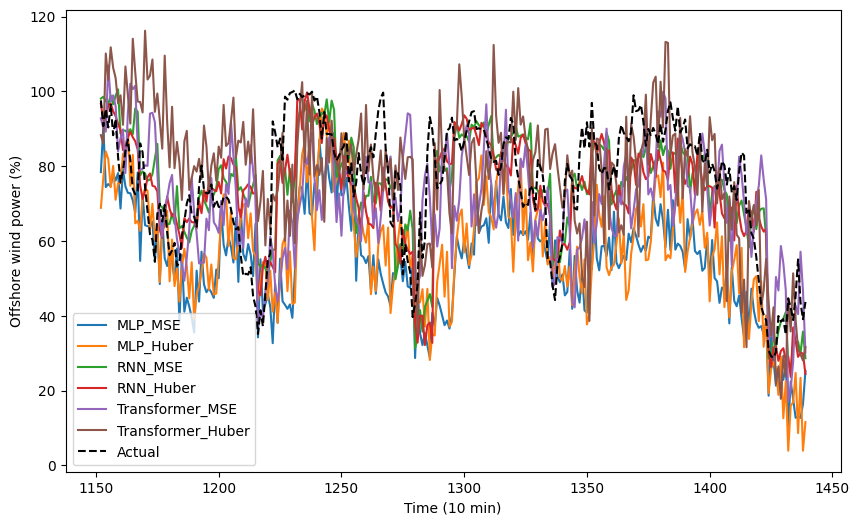

In [36]:
plt.figure(figsize=(10, 6))
for model_name, preds in predictions.items():
    preds = preds * (max_Y - min_Y) + min_Y
    plt.plot(test_indices, preds.flatten(), label=model_name)
Y_test = Y_test * (max_Y - min_Y) + min_Y
plt.plot(test_indices, Y_test.flatten(), label='Actual', linestyle='--', color='black')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore wind power (%)')
plt.legend()
plt.show()

In [37]:
results = {
    "Index": [],
    "Model": [],
    "MSE": [],
    "Huber": []
}
for model_name, history in histories.items():
    model_arch, model_loss = model_name.split("_")
    if model_loss in ["MSE", "Huber"]:
        results["Index"].extend(["MAE", "MAPE", "RMSE"])
        results["Model"].extend([model_arch] * 3)
        results["MSE"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "MSE" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "MSE" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "MSE" else None,
        ])
        results["Huber"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "Huber" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "Huber" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "Huber" else None,
        ])
df = pd.DataFrame(results)
df.sort_values(by=["Index", "Model"], inplace=True)
df = df.reset_index(drop=True)
for i in range(1, len(df), 2):
    odd_row = i
    even_row = i - 1
    if even_row < len(df):
        df.iloc[odd_row] = df.iloc[odd_row].fillna(df.iloc[even_row])
df8 = df.iloc[1::2].reset_index(drop=True)
df8

,Index,Model,MSE,Huber
0,MAE,MLP,0.101446,0.094266
1,MAE,RNN,0.083746,0.080241
2,MAE,Transformer,0.084633,0.087689
3,MAPE,MLP,39.620337,24.744039
4,MAPE,RNN,63.023063,50.989587
5,MAPE,Transformer,54.103031,45.640831
6,RMSE,MLP,0.135167,0.128540
7,RMSE,RNN,0.119638,0.113844
8,RMSE,Transformer,0.108101,0.110085


#### ●●● t+16

In [38]:
lookback, prediction_steps = 144, 16
X, Y = create_features_targets(denoised_data, lookback=lookback, prediction_steps=prediction_steps)
ind = int(len(X) * 0.8)
X_train, Y_train = X[:ind], Y[:ind]
X_test, Y_test = X[ind:], Y[ind:]
min_X = np.min(X_train, axis=0)
max_X = np.max(X_train, axis=0)
min_Y = np.min(Y_train, axis=0)
max_Y = np.max(Y_train, axis=0)
X_train = (X_train - min_X) / (max_X - min_X)
Y_train = (Y_train - min_Y) / (max_Y - min_Y)
X_test = (X_test - min_X) / (max_X - min_X)
Y_test = (Y_test - min_Y) / (max_Y - min_Y)

In [39]:
epochs = 50
batch_size = 32
optimizer = 'Adam'
loss_functions = {
    "MSE": MeanSquaredError(),
    "Huber": Huber()
}
metrics = [MeanAbsoluteError(), RootMeanSquaredError(), MeanAbsolutePercentageError()]
input_shape = (lookback,)
models = {
    "MLP_MSE": MLP_model((lookback, 8), prediction_steps),
    "MLP_Huber": MLP_model((lookback, 8), prediction_steps),
    "RNN_MSE": RNN_model((lookback, 8), prediction_steps),
    "RNN_Huber": RNN_model((lookback, 8), prediction_steps),
    "Transformer_MSE": Transformer_model((lookback, 8), prediction_steps),
    "Transformer_Huber": Transformer_model((lookback, 8), prediction_steps)
}

In [40]:
histories = {}
for model_name, model in models.items():
    loss_type = "MSE" if "MSE" in model_name else "Huber"
    histories[model_name] = train_model(model, loss_functions[loss_type], X_train, Y_train, epochs, batch_size, optimizer, metrics)
    print(f"Training {model_name} with {loss_type} loss done.")

Training MLP_MSE with MSE loss done.
Training MLP_Huber with Huber loss done.
Training RNN_MSE with MSE loss done.
Training RNN_Huber with Huber loss done.
Training Transformer_MSE with MSE loss done.
Training Transformer_Huber with Huber loss done.


In [41]:
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test, verbose=0)

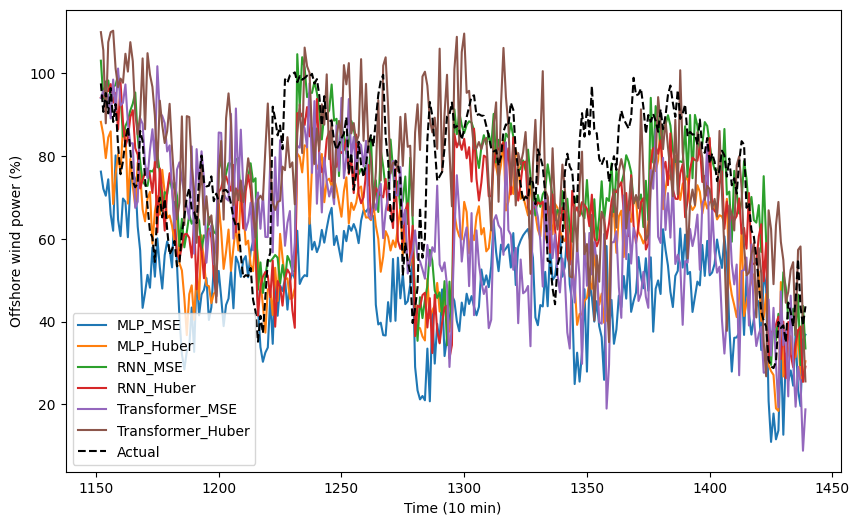

In [42]:
plt.figure(figsize=(10, 6))
for model_name, preds in predictions.items():
    preds = preds * (max_Y - min_Y) + min_Y
    plt.plot(test_indices, preds.flatten(), label=model_name)
Y_test = Y_test * (max_Y - min_Y) + min_Y
plt.plot(test_indices, Y_test.flatten(), label='Actual', linestyle='--', color='black')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore wind power (%)')
plt.legend()
plt.show()

In [43]:
results = {
    "Index": [],
    "Model": [],
    "MSE": [],
    "Huber": []
}
for model_name, history in histories.items():
    model_arch, model_loss = model_name.split("_")
    if model_loss in ["MSE", "Huber"]:
        results["Index"].extend(["MAE", "MAPE", "RMSE"])
        results["Model"].extend([model_arch] * 3)
        results["MSE"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "MSE" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "MSE" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "MSE" else None,
        ])
        results["Huber"].extend([
            history.history["mean_absolute_error"][-1] if model_loss == "Huber" else None,
            history.history["mean_absolute_percentage_error"][-1] / 100e2 if model_loss == "Huber" else None,
            history.history["root_mean_squared_error"][-1] if model_loss == "Huber" else None,
        ])
df = pd.DataFrame(results)
df.sort_values(by=["Index", "Model"], inplace=True)
df = df.reset_index(drop=True)
for i in range(1, len(df), 2):
    odd_row = i
    even_row = i - 1
    if even_row < len(df):
        df.iloc[odd_row] = df.iloc[odd_row].fillna(df.iloc[even_row])
df16 = df.iloc[1::2].reset_index(drop=True)
df16

,Index,Model,MSE,Huber
0,MAE,MLP,0.139649,0.135072
1,MAE,RNN,0.128350,0.127774
2,MAE,Transformer,0.092818,0.092020
3,MAPE,MLP,205.882262,184.605112
4,MAPE,RNN,228.473100,233.245550
5,MAPE,Transformer,115.626150,74.634631
6,RMSE,MLP,0.178896,0.170270
7,RMSE,RNN,0.173478,0.173530
8,RMSE,Transformer,0.119114,0.116872


---